In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import timeit
from typing import Union
import numpy as np

from graphiq.backends.stabilizer.compiler import StabilizerCompiler
from graphiq.backends.density_matrix.compiler import DensityMatrixCompiler

from graphiq.metrics import Infidelity
from graphiq.state import QuantumState
from graphiq.solvers.time_reversed_solver import TimeReversedSolver
from graphiq.benchmarks.system_info import print_system_info

colors = sns.color_palette('crest', 4)

In [61]:
print_system_info()

System: Darwin 21.6.0
Machine: x86_64
Processor: i386
CPU: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Number of physical cores: 6
Number of logical cores: 12
Max CPU frequency: 2600.00 Mhz
Total memory: 16.00 GB
Python version: 3.9.6


## Runtime scaling for mapping target state to generating circuit via `TimeReversedSolver`

In [62]:
def generate_circuit(n: int):
    compiler = StabilizerCompiler()
    graph = nx.Graph([(i, i+1) for i in range(0, n-1)])
    target = QuantumState(graph, rep_type="graph")
    metric = Infidelity(target=target)
    
    solver = TimeReversedSolver(target=target, metric=metric, compiler=compiler)
    solver.solve()
    infidelity, circuit = solver.result
    return circuit

In [63]:
ns = np.array(list(range(2, 50)))
results_solver, circuits = {}, {}
for n in ns:
    circuit = generate_circuit(n)
    
    timer = timeit.Timer(lambda: generate_circuit(n))
    time = timer.timeit(number=3)
    
    circuits[n] = circuit
    results_solver[n] = time

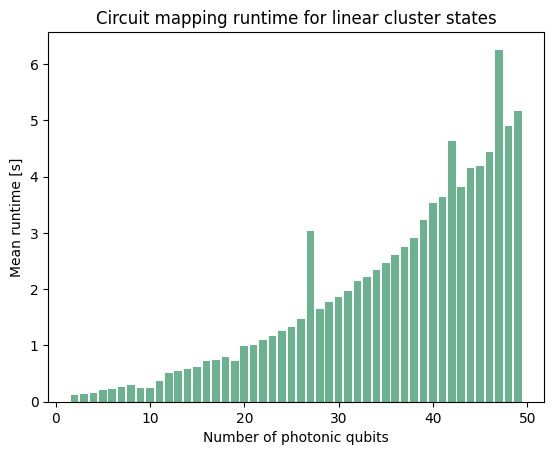

In [67]:
fig, ax = plt.subplots()
ax.bar(results_solver.keys(), results_solver.values(), color=colors[0], label="TimeReversedSolver")
ax.set(xlabel="Number of photonic qubits", ylabel="Mean runtime [s]", title="Circuit mapping runtime for linear cluster states")
plt.show()

## Runtime scaling for simulating generating circuits with `DensityMatrixCompiler` and `StabilizerCompiler`

In [65]:
def simulate_circuit(circuit, compiler):
    state = compiler.compile(circuit)
    return 

results_compiler = {}
for compiler in (DensityMatrixCompiler(), StabilizerCompiler()):
    _results = {}
    for n in ns:
        if isinstance(compiler, DensityMatrixCompiler) and n > 9:
            continue
        timer = timeit.Timer(lambda: simulate_circuit(circuits[n], compiler))
        time = timer.timeit(number=5)
        
        _results[n] = time
    results_compiler[compiler.__class__.__name__] = _results

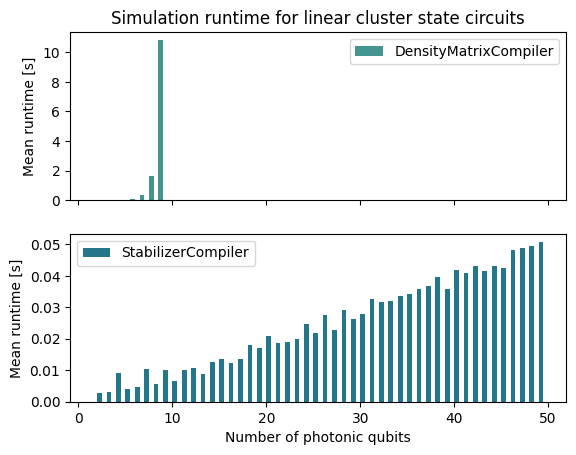

In [66]:
width = 0.5 

fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].bar(
    np.array(list(results_compiler['DensityMatrixCompiler'].keys())) - width/2, 
    results_compiler['DensityMatrixCompiler'].values(), 
    width, label='DensityMatrixCompiler', color=colors[1]
)
axs[1].bar(
    np.array(list(results_compiler['StabilizerCompiler'].keys())) + width/2, 
    results_compiler['StabilizerCompiler'].values(), 
    width, label='StabilizerCompiler', color=colors[2]
)
ax.set_xticks(ns)
for ax in axs:
    ax.legend()
    ax.set(ylabel="Mean runtime [s]")
axs[0].set(title="Simulation runtime for linear cluster state circuits")
axs[1].set(xlabel="Number of photonic qubits")
plt.show()